In [1]:
import os
import torch
import math
import torchvision
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from utils import VisionTransformer, get_args, get_model, get_checkpoint

/Users/ericmonzon/mambaforge/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datetime.now().strftime("%m-%d-%Y-%H:%M") 

'07-07-2024-18:02'

In [3]:
args = get_args(os.path.join("config", "train_config.yaml"))

args

{'seed': 42,
 'patience': 10,
 'img_size': 32,
 'variant': 'base',
 'batch_size': 20,
 'num_classes': 10,
 'weight_decay': 0.0001,
 'learning_rate': 0.0001,
 'dropout_probability': 0.0}

In [4]:
model = get_model(
        args["img_size"], 4, variant=args["variant"], dropout_probability=0.0, num_classes=10
    )

In [5]:
model

VisionTransformer(
  (patchifier): Patchifier(
    (proj): Conv2d(3, 768, kernel_size=(4, 4), stride=(4, 4))
  )
  (position_encoder): PositionEncoder(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (0): TransformerEncoder(
      (multihead_attention): MultiHeadAttention(
        (q_w): Linear(in_features=768, out_features=768, bias=True)
        (k_w): Linear(in_features=768, out_features=768, bias=True)
        (v_w): Linear(in_features=768, out_features=768, bias=True)
        (fc): Linear(in_features=768, out_features=768, bias=True)
      )
      (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU(approximate='none')
        (3): Linear(in_features=3072, out_features=768, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (multihead_attention)

In [6]:
dest = os.path.join("..", "data")

transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

train = CIFAR10(root=dest, train=True, download=True, transform=transform)
test = CIFAR10(root=dest, train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
args_path = os.path.join("config", "train_config.yaml")
args = get_args(args_path)

In [8]:
train_loader = DataLoader(train, batch_size=5, shuffle=True)
val_loader = DataLoader(test, batch_size=5, shuffle=False)

In [9]:
patchifier = model.patchifier

In [10]:
img, label = next(iter(train_loader))

In [11]:
test_img = img[0]

patchified = patchifier(img)

In [12]:
img.shape

torch.Size([5, 3, 32, 32])

In [13]:
patchified.shape

torch.Size([5, 65, 768])

In [14]:
position_encoder = model.position_encoder

position_encoding = position_encoder.get_position_encoding() 

In [15]:
combined_embedding = position_encoder(patchified)

combined_embedding.shape

torch.Size([5, 65, 768])

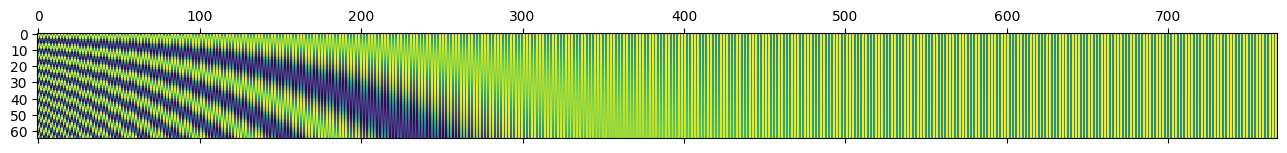

In [16]:
plt.matshow(position_encoding)

In [17]:
encoder = model.encoder

encoder(patchified).shape

torch.Size([5, 65, 768])

In [18]:
logits = model(img)

logits.shape

torch.Size([5, 10])

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
criterion(logits, label)

tensor(3.2268, grad_fn=<NllLossBackward0>)

In [21]:
label.shape

torch.Size([5])

In [22]:
label

tensor([0, 1, 4, 3, 4])

In [23]:
confidence = F.softmax(logits, dim=1)

confidence.shape

torch.Size([5, 10])

In [24]:
pred = torch.argmax(confidence, dim=1)

In [25]:
type(f1_score(label, pred, average="macro"))

numpy.float64

In [26]:
type(label)

torch.Tensor

In [27]:
type(pred)

torch.Tensor

In [28]:
pred


tensor([2, 5, 2, 2, 2])

In [29]:
len(test)

10000

In [30]:
len(train)

50000

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min")

In [34]:
checkpoint = get_checkpoint(10, model, optimizer, scheduler)

In [35]:
torch.save(checkpoint, "test.pth")

In [37]:
test_ckpt = torch.load("test.pth")